## APS 360 Project Garbage Classification

![](https://i0.wp.com/www.sustainabilitycurriculum.co.uk/wp-content/uploads/2018/05/bins.jpg?ssl=1)



**Project Resources**
* Colab Link: https://colab.research.google.com/drive/1-1YyMS6jjtuq8OrJYm1MAxU0EiqW8x-E?usp=sharing
* Project Progress Folder Link:https://docs.google.com/spreadsheets/d/11e0DnKlxfQfzFgkxfv8E3HTMpVj-C6wQIxCZlTbwdbY/edit#gid=0
* Data Management Folder Link: https://docs.google.com/spreadsheets/d/1YC4uRiD7SFJLeON9VkJC4c7AUdS5szPLB-_Ro_PF27c/edit?usp=sharing

**Data Resources**
* Data path Link: https://drive.google.com/drive/folders/1BxKKc4OR2xvPLSqmNluh9f4zpI2PTwxi?usp=sharing
* Data Management Table: https://docs.google.com/spreadsheets/d/1YC4uRiD7SFJLeON9VkJC4c7AUdS5szPLB-_Ro_PF27c/edit?usp=sharing



# 1.0 Pre Work *

* Import any necessary library to support our model
* Connect with Goolge drive file, Since we store all the Garbage Datasets on that place
* Adding a progress status line

In [ ]:
# Library
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import torchvision.models as models    # Import model.Resnet50
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder


from torch.autograd import Variable
from io import open
import os
from PIL import Image
import pathlib
import glob
import cv2


from torch.utils.data import DataLoader


# - - - - - - - - - - - - - - - #
# Mount with my Google drive 
from google.colab import drive
drive.mount('/content/gdrive')


# - - - - - - - - - - - - - - - #
# Define the progressing line
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

Mounted at /content/gdrive


In [ ]:
# Checking for device
# Note: It should be print out as "cuda", which means running for GPU.

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# 2.0  Data Collection
>**Note:** 
Before we get the data, please creat a **New Directory call APS360_Lab/Project/**, and simply move the sharing file into that folder on the google drive.
We manage All the data from "Our Data Link" which list the link below, and we also make the outline for which type of data that we consider. Besides, we get the data mainly from the "Resource Data link" link, whcih is provided by "Huawei Technologies Company".


* Data path Link: https://drive.google.com/drive/folders/1BxKKc4OR2xvPLSqmNluh9f4zpI2PTwxi?usp=sharing
* Data Management Table: https://docs.google.com/spreadsheets/d/1YC4uRiD7SFJLeON9VkJC4c7AUdS5szPLB-_Ro_PF27c/edit?usp=sharing
* Resource Data link: https://modelarts-competitions.obs.cn-north-1.myhuaweicloud.com/garbage_classify/dataset/garbage_classify.zip).

## 2.1 init Data path and init loading data function * 

In [ ]:
# List Google drive data path
GoogleDrivePath = '/content/gdrive/MyDrive/APS360_Lab/Project/'
DataPath = GoogleDrivePath + 'Data/'

TrainPath = DataPath + 'train'
ValidPath = DataPath + 'validation'
TestPath = DataPath + 'test'

def get_img_data_loader(batch_size = 1):
    transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
    # Load data
    trainset = torchvision.datasets.ImageFolder(TrainPath, transform=transform)
    validset = torchvision.datasets.ImageFolder(ValidPath, transform=transform)
    testset  = torchvision.datasets.ImageFolder(TestPath, transform=transform)

    # Put into data loader
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
    val_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader

def get_data_loader(train_batch_size = 64, valid_batch_size = 32, test_batch_size = 32):
    print("Start Loading data....")
    transform=transforms.Compose([
        transforms.Resize((150,150)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
        transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                            [0.5,0.5,0.5])
    ])

    # Load data
    trainset = torchvision.datasets.ImageFolder(TrainPath, transform=transform)
    validset = torchvision.datasets.ImageFolder(ValidPath, transform=transform)
    testset  = torchvision.datasets.ImageFolder(TestPath, transform=transform)

    # Put into data loader
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size,shuffle=True)
    val_loader = torch.utils.data.DataLoader(validset, batch_size=valid_batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=True)
    print("Finish Load data")
    return train_loader, val_loader, test_loader


def get_relevant_indices(dataset, classes, target_classes):
    # Show the processing status line
    totalProgress = len(dataset)
    progressIndex = 0
    train_progress = display(progress(progressIndex, totalProgress), display_id=True)


    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)

        progressIndex +=1
        train_progress.update(progress(progressIndex,totalProgress))
    return indices



def get_img_augo_data_loader(target_classes, batch_size=1, img_size = 224):
    print("Start Loading data....")

    transform=transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),   # rotation
        transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
        transforms.Normalize(mean=[0.485,0.456,0.406],
                              std=[0.229,0.224,0.225])
        # transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
        #                     [0.5,0.5,0.5])
    ])

    # Load data
    trainset = torchvision.datasets.ImageFolder(TrainPath, transform=transform)
    validset = torchvision.datasets.ImageFolder(ValidPath, transform=transform)
    testset  = torchvision.datasets.ImageFolder(TestPath, transform=transform)

    # Put into data loader
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
    val_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

    print("Finish Load data")

    return train_loader, val_loader, test_loader

def get_data_loader_simple (target_classes, train_batch=1, img_size = 150):
    print("Start Loading data....")


    transform=transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()  #0-255 to 0-1, numpy to tensors
        # transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
        #                     [0.5,0.5,0.5])
    ])

    # Load data
    trainset = torchvision.datasets.ImageFolder(TrainPath, transform=transform)
    validset = torchvision.datasets.ImageFolder(ValidPath, transform=transform)
    testset  = torchvision.datasets.ImageFolder(TestPath, transform=transform)
    
    print("Get train relevant indices...")
    train_relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    print("Get train relevant indices...")
    val_relevant_indices = get_relevant_indices(validset, classes, target_classes)
    print("Get train relevant indices...")
    test_relevant_indices = get_relevant_indices(testset, classes, target_classes)
    print("Finish get all relevant indices...")

    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(train_relevant_indices)
    np.random.shuffle(val_relevant_indices)
    np.random.shuffle(test_relevant_indices)

    
    train_sampler = SubsetRandomSampler(train_relevant_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=train_batch,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(val_relevant_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=train_batch,
                                              num_workers=1, sampler=val_sampler)
    test_sampler = SubsetRandomSampler(test_relevant_indices)
    test_loader = torch.utils.data.DataLoader(trainset, batch_size=train_batch,
                                             num_workers=1, sampler=test_sampler)

    print("Finish Load data")
    return train_loader, val_loader, test_loader

# primary_categories = ['hazardous_waste', 'kitchen_waste', 'other_garbage', 'recyclable']
def get_primary_category(index):
  if (index>=0 and index <=5):
      return 'other_garbage'
  elif (index>5 and index <=13): 
      return 'kitchen_waste'
  elif (index>13 and index <=36): 
      return 'recyclable'
  else:
      return 'hazardous_waste'



def show_sample_figures(dataset):
  # plot the partial images from the given dataset
  # adopt similar strategies from Lab2 part(a)

  train_imgNum = 0
  fig1 = plt.figure(figsize=(23, 12))
  for images, labels in dataset:
      # since batch_size = 1, there is only 1 image in `images`
      image = images[0]
      # place the colour channel at the end, instead of at the beginning
      img = np.transpose(image, (1,2,0))

      ax = fig1.add_subplot(3,7,train_imgNum+1, xticks=[], yticks=[])

      
      index = (labels.item()+1)
      title = (str(index) + " " + get_primary_category(labels.item()))
      ax.set_title(title)

      plt.imshow(img)

      train_imgNum += 1
      if train_imgNum > 20:
          break


def show_sample_figures_simple (dataset):
  # index of training image number
  train_imgNum = 0

  # plot the partial images from the given dataset
  # adopt similar strategies from Lab2 part(a)
  print('Data From train_loader')
  fig1 = plt.figure(figsize=(22, 13))
  for images, labels in train_loader:
      # since batch_size = 1, there is only 1 image in `images`
      image = images[0]
      # place the colour channel at the end, instead of at the beginning
      img = np.transpose(image, (1,2,0))

      ax = fig1.add_subplot(4,6,train_imgNum+1, xticks=[], yticks=[])

      # index = int(str[:2])
      # print(index)

      title = (classes[labels] + "/" + get_primary_category(labels))
      ax.set_title(title)

      plt.imshow(img)

      train_imgNum += 1
      if train_imgNum > 23:
          break

def get_categories():
  cagpath=pathlib.Path(TrainPath)
  classes=sorted([j.name.split('/')[-1] for j in cagpath.iterdir()])
  return classes

def get_total_number_data():
  train_count=len(glob.glob(TrainPath+'/**/*.jpg'))
  valid_count=len(glob.glob(ValidPath+'/**/*.jpg'))
  test_count=len(glob.glob(TestPath+'/**/*.jpg'))

  return train_count,valid_count,test_count

In [ ]:
classes = get_categories()
print(classes)
target_classes = classes[:]

['hazardous_waste', 'kitchen_waste', 'other_waste', 'recyclable']


## 2.2 Example of Showing Data(Method A)

Data From train_loader
Number of training examples:  2331
Number of validation examples:  195
Number of test examples:  10


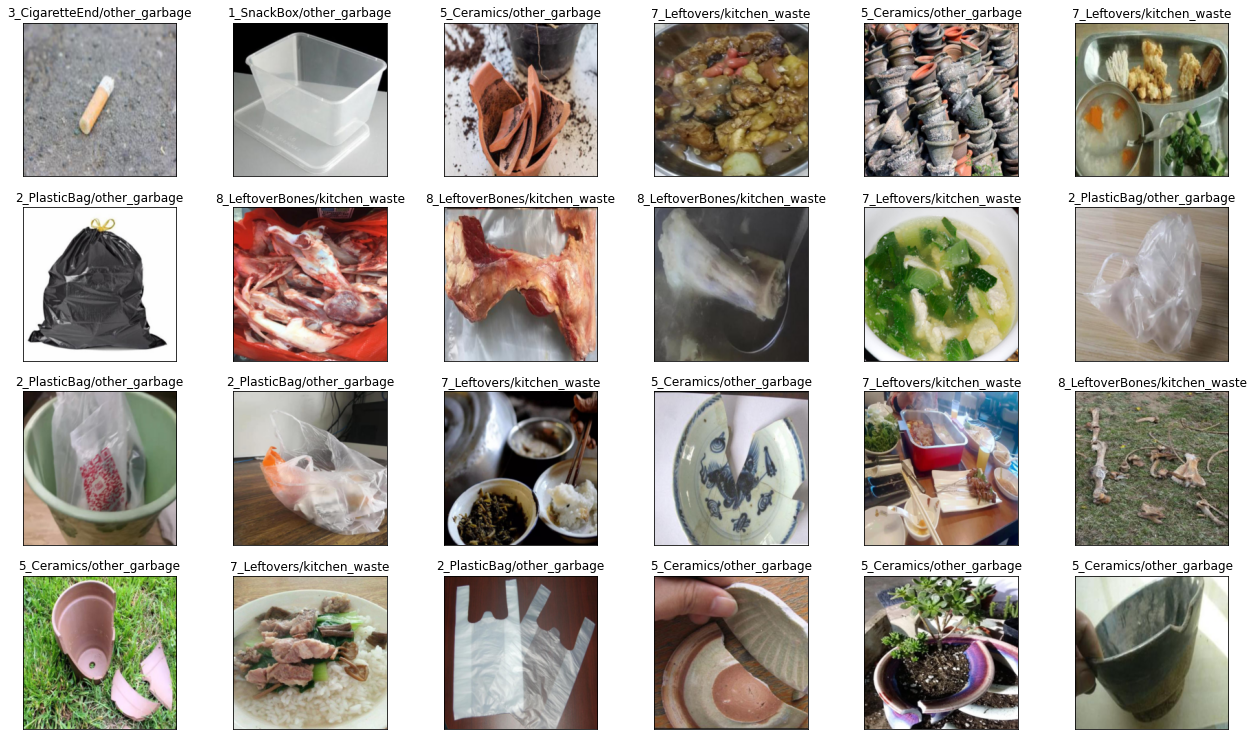

In [ ]:
# First attempt to load the data, and also visualise the data from train_loader
train_loader, val_loader, test_loader = get_img_data_loader()
show_sample_figures_simple(train_loader)
print("Number of training examples: ", len(train_loader))
print("Number of validation examples: ", len(val_loader))
print("Number of test examples: ", len(test_loader))

## 2.3 Example of showing Data after "Data Augomentation" (Method B)

Start Loading data....
Finish Load data
Data From train_loader


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Number of training examples:  2226
Number of validation examples:  607
Number of test examples:  607


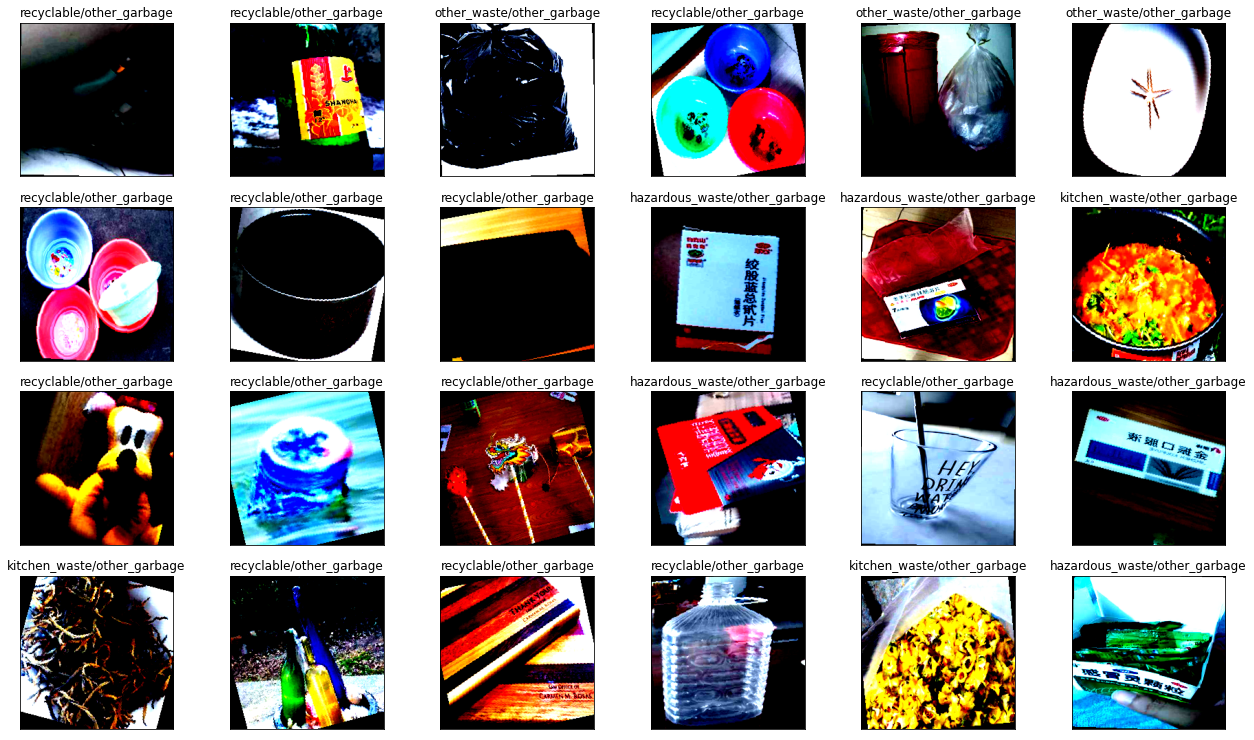

In [ ]:
# First attempt to load the data, and also visualise the data from train_loader
train_loader, val_loader, test_loader = get_img_augo_data_loader(target_classes)
show_sample_figures_simple(train_loader)
print("Number of training examples: ", len(train_loader))
print("Number of validation examples: ", len(val_loader))
print("Number of test examples: ", len(test_loader))

tensor([0])
10_MoldyFruit
Secondary Categoryies index is:  10


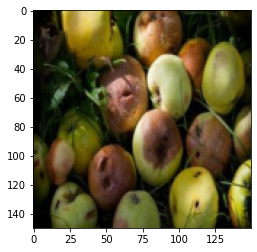

In [ ]:
# show one particular image information
for img, label in train_loader:

  # print the label 
  print(label)
  
  str = classes[label]
  print(classes[label])

  # get the index corresponding with their secondary type
  index = int(str[:2])
  print("Secondary Categoryies index is: ", index)

  img = img[0]
  image = np.transpose(img, (1,2,0))
  plt.imshow(image)
  break

In [ ]:
len(train_loader)

6734

In [ ]:
train_count,valid_count,test_count = get_total_number_data()
print(train_count)
print(valid_count)
print(test_count)

6734
645
10


## 2.4 Reason of resize scale choose

> we choose the scale base on checking the relative calearance of the images


In [ ]:
TestPath = DataPath + 'Test'


import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
   # print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))


def show_sample_figures(dataset):
  # plot the partial images from the given dataset
  # adopt similar strategies from Lab2 part(a)

  train_imgNum = 0
  fig1 = plt.figure(figsize=(23, 12))
  for images, labels in dataset:
      # since batch_size = 1, there is only 1 image in `images`
      image = images[0]
      # place the colour channel at the end, instead of at the beginning
      img = np.transpose(image, (1,2,0))

      ax = fig1.add_subplot(3,7,train_imgNum+1, xticks=[], yticks=[])

      
      index = (labels.item()+1)
      title = (str(index) + " " + get_primary_category(labels.item()))
      ax.set_title(title)

      plt.imshow(img)

      train_imgNum += 1
      if train_imgNum > 20:
          break



def show_sample_scale_figures():
    transformations1 = transforms.Compose([transforms.Resize((20, 20)), transforms.ToTensor()])
    transformations2 = transforms.Compose([transforms.Resize((70, 70)), transforms.ToTensor()])
    transformations3 = transforms.Compose([transforms.Resize((150, 150)), transforms.ToTensor()])
    transformations4 = transforms.Compose([transforms.Resize((300, 300)), transforms.ToTensor()])

    dataset1 = ImageFolder(TrainPath, transform = transformations1)
    dataset2 = ImageFolder(TrainPath, transform = transformations2)
    dataset3 = ImageFolder(TrainPath, transform = transformations3)
    dataset4 = ImageFolder(TrainPath, transform = transformations4)

    # train_imgNum = 0
    fig1 = plt.figure(figsize=(15, 6))

    img1, label1 = dataset1[556]
    img2, label2 = dataset2[556]
    img3, label3 = dataset3[556]
    img4, label4 = dataset4[556]

    ax = fig1.add_subplot(1,4,1, xticks=[], yticks=[])
    ax.set_title("20*20")
    plt.imshow(img1.permute(1, 2, 0))
    
    ax = fig1.add_subplot(1,4,2, xticks=[], yticks=[])
    ax.set_title("70*70")
    plt.imshow(img2.permute(1, 2, 0))

    ax = fig1.add_subplot(1,4,3, xticks=[], yticks=[])
    ax.set_title("150*150")
    plt.imshow(img3.permute(1, 2, 0))

    ax = fig1.add_subplot(1,4,4, xticks=[], yticks=[])
    ax.set_title("300*300")
    plt.imshow(img4.permute(1, 2, 0))

    
    # index = (labels.item()+1)
    # title = (str(index) + " " + get_primary_category(labels.item()))
    # ax.set_title(title)

    # plt.imshow(img)

    # if train_imgNum > 20:
    #       break 



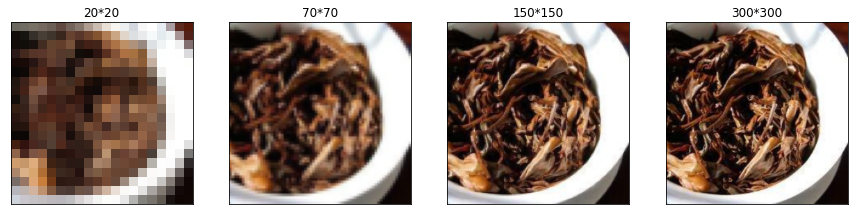

In [ ]:
show_sample_scale_figures()

# 3.0 Base Model

# 4.0 Primary Model

## 4.1 VGG19 Model

In [ ]:
import tensorflow as tf
import keras, os
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.layers import Flatten,Dense,Dropout
from keras.preprocessing.image import ImageDataGenerator


In [ ]:
VGG = keras.applications.VGG19(input_shape=(224,224,3), include_top=False, weights='imagenet')
VGG.trainable = False

model = keras.Sequential([
                          VGG,
                          keras.layers.Flatten(),
                          keras.layers.Dense(units=256, activation="relu"),
                          keras.layers.Dense(units=256, activation="relu"),
                          keras.layers.Dense(units=4, activation="softmax")
])

model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])


80142336/80134624 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 26,513,988
Trainable params: 6,489,604
Non-trainable params: 20,024,384
_________________________________________________________________


### 4.1.1 Data without data augomentation

In [ ]:
dataGenerT = ImageDataGenerator()
trainData = dataGenerT.flow_from_directory(directory = TrainPath, target_size=(244,244))

dataGenerV = ImageDataGenerator()
validData = dataGenerV.flow_from_directory(directory = ValidPath, target_size=(244,244))

Found 2226 images belonging to 4 classes.
Found 607 images belonging to 4 classes.


In [ ]:
hist = model.fit_generator(steps_per_epoch=40, generator=trainData, validation_data=validData, validation_steps=10, epochs=5)
model.save('vggBaseModel1.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
40/40 [==============================] - 449s 10s/step - loss: 13.3309 - accuracy: 0.5085 - val_loss: 2.2778 - val_accuracy: 0.7344
Epoch 2/5
40/40 [==============================] - 175s 4s/step - loss: 1.5478 - accuracy: 0.8525 - val_loss: 2.5132 - val_accuracy: 0.7312
Epoch 3/5
40/40 [==============================] - 82s 2s/step - loss: 1.3711 - accuracy: 0.8488 - val_loss: 2.0802 - val_accuracy: 0.7656
Epoch 4/5
40/40 [==============================] - 41s 1s/step - loss: 0.8780 - accuracy: 0.8975 - val_loss: 2.0518 - val_accuracy: 0.8031
Epoch 5/5
40/40 [==============================] - 26s 666ms/step - loss: 0.3835 - accuracy: 0.9378 - val_loss: 1.7415 - val_accuracy: 0.8250


### 4.1.2 Data with data augomentation

In [ ]:
DataPath = GoogleDrivePath + 'Datasets/'
train_dir = DataPath + 'Train'
validation_dir = DataPath + 'Valid'

TestPath = DataPath + 'Test'

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
 
test_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        directory = train_dir, 
        target_size=(224, 224)
        )                              
 
validation_generator = test_datagen.flow_from_directory(
        directory = validation_dir, 
        target_size=(224, 224)
        )  

Found 8321 images belonging to 22 classes.
Found 110 images belonging to 5 classes.


In [ ]:
hist = model.fit_generator(steps_per_epoch=30, generator=train_generator, validation_data=validation_generator, validation_steps=10, epochs=5)
model.save('vggBaseModel2.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
30/30 [==============================] - 19s 618ms/step - loss: 3.9161 - accuracy: 0.1428 - val_loss: 3.3018 - val_accuracy: 0.1437
Epoch 2/5
30/30 [==============================] - 18s 611ms/step - loss: 1.9770 - accuracy: 0.3872 - val_loss: 3.5991 - val_accuracy: 0.1469
Epoch 3/5
30/30 [==============================] - 18s 612ms/step - loss: 1.6472 - accuracy: 0.4866 - val_loss: 3.8872 - val_accuracy: 0.1719
Epoch 4/5
30/30 [==============================] - 18s 612ms/step - loss: 1.4458 - accuracy: 0.5700 - val_loss: 4.4087 - val_accuracy: 0.1531
Epoch 5/5
30/30 [==============================] - 19s 623ms/step - loss: 1.3782 - accuracy: 0.5754 - val_loss: 4.6824 - val_accuracy: 0.1469


### 4.1.3 Base Model Performance and Evaluate

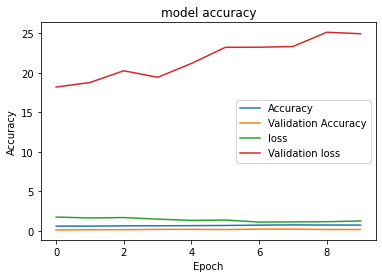

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel('Accuracy')
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Validation Accuracy", "loss", 'Validation loss'])
plt.show()

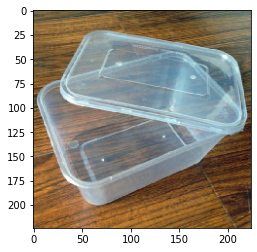

In [ ]:
from keras.preprocessing import image

img = image.load_img(TestPath+"/1/1_snackBox1.jpg", target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)


[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.7750784e-31
 1.8246594e-25 0.0000000e+00 0.0000000e+00 0.0000000e+00 4.5517491e-28
 1.0000000e+00 8.1318695e-15 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 8.6209970e-24 2.0308438e-28 0.0000000e+00 0.0000000e+00]


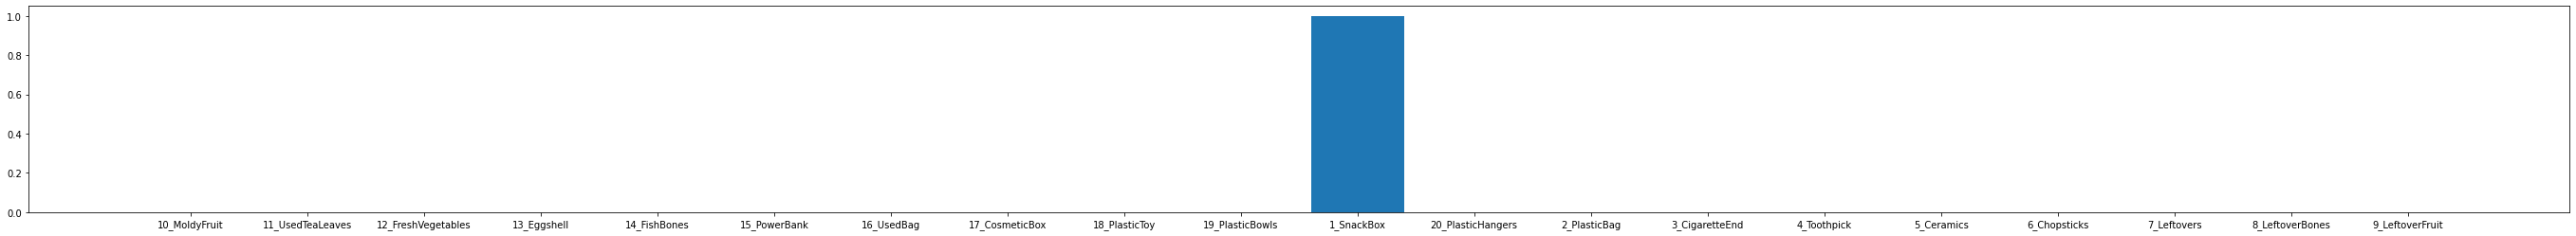

In [ ]:
from keras.models import load_model
saved_model = load_model("vggclf.h5")
output = saved_model.predict(img)

# fig = plt.figure()

ax=plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width*8 , box.height])

data = (output[0]).tolist()
ypos = np.arange(len(classes))
plt.xticks(ypos, classes)
plt.bar(ypos, data)
print(output[0])

__________________________________________________________________________________________

__________________________________________________________________________________________
### 4.1.4 Previous work on compare with 4 different type of secondary categories 
Do not run on this part, because we use thie part for stroing the model performance, and we can use it for compare with other models by adjusting the hyper-parameter.

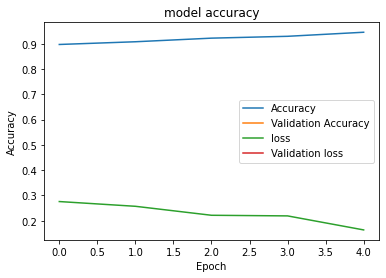

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel('Accuracy')
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Validation Accuracy", "loss", 'Validation loss'])
plt.show()

## 4.2 Resnet18 Model

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

In [ ]:
class ResBlk(nn.Module):
    def __init__(self, ch_in, ch_out, stride=1):
        super(ResBlk, self).__init__()
        self.conv1 = nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=stride, padding=1)  # resnet block
        self.bn1 = nn.BatchNorm2d(ch_out)
        self.conv2 = nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(ch_out)

        self.extra = nn.Sequential()
        if ch_out != ch_in:
            self.extra = nn.Sequential(
                nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=stride),
                nn.BatchNorm2d(ch_out)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.extra(x) + out
        out = F.relu(out)
        return out


class ResNet18(nn.Module):

    def __init__(self, num_class):
        super(ResNet18, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=3, padding=0),
            nn.BatchNorm2d(16)
        )

        self.blk1 = ResBlk(16, 32, stride=3)
        self.blk2 = ResBlk(32, 64, stride=3)    #[b, 128, h, w] => [b, 256, h, w]
        self.blk3 = ResBlk(64, 128, stride=2)         
        self.blk4 = ResBlk(128, 256, stride=2)
        self.outlayer = nn.Linear(256*3*3, num_class)

    def forward(self, x):
        x = F.relu(self.conv1(x))

        x = self.blk1(x)
        x = self.blk2(x)
        x = self.blk3(x)
        x = self.blk4(x)

        x = x.view(x.size(0), -1)
        x = self.outlayer(x)
        return x




In [ ]:
from torchsummary import summary
import torchvision.models as PyTorchModels
r = PyTorchModels.resnet18()
num_in_channels = 1
num_out_channels = r.conv1.out_channels
size_kernel = r.conv1.kernel_size
num_in_features = r.fc.in_features
classes = 4
r.conv1 = nn.Conv2d(in_channels=num_in_channels, out_channels=num_out_channels, kernel_size=size_kernel)
r.fc = nn.Linear(in_features=num_in_features, out_features=classes)
model = r
summary(model.cuda(), (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 26, 26]           3,200
       BatchNorm2d-2           [-1, 64, 26, 26]             128
              ReLU-3           [-1, 64, 26, 26]               0
         MaxPool2d-4           [-1, 64, 13, 13]               0
            Conv2d-5           [-1, 64, 13, 13]          36,864
       BatchNorm2d-6           [-1, 64, 13, 13]             128
              ReLU-7           [-1, 64, 13, 13]               0
            Conv2d-8           [-1, 64, 13, 13]          36,864
       BatchNorm2d-9           [-1, 64, 13, 13]             128
             ReLU-10           [-1, 64, 13, 13]               0
       BasicBlock-11           [-1, 64, 13, 13]               0
           Conv2d-12           [-1, 64, 13, 13]          36,864
      BatchNorm2d-13           [-1, 64, 13, 13]             128
             ReLU-14           [-1, 64,

# 5.0 Training Data

## 5.1 Training Data Function *

In [ ]:
def train(model, train_loader, valid_loader, lr=0.001, num_epochs=10):
    print("Start Training")
    # display the train progress 
    totalProgress = num_epochs * (len(train_loader) + len(valid_loader))
    progressIndex = 0
    train_progress = display(progress(progressIndex, totalProgress), display_id=True)

    # get total number of count
    train_count,valid_count,test_count = get_total_number_data()

    #Optmizer and loss function
    optimizer=optim.Adam(model.parameters(),lr=lr,weight_decay=0.0001)
    loss_function=nn.CrossEntropyLoss()

    iters, losses, train_acc, val_acc = [], [], [], []
    best_acc = 0.0

    for epoch in range(num_epochs):
          model.train()
          train_accuracy=0.0
          train_loss=0.0
          for i, (images,labels) in enumerate(train_loader):
                #############################################
                # To Enable GPU Usage
                if torch.cuda.is_available():
                    images = images.cuda()
                    labels = labels.cuda()
                #############################################
                    
                optimizer.zero_grad()
                
                outputs=model(images)
                loss=loss_function(outputs,labels)
                loss.backward()
                optimizer.step()
                
                
                train_loss+= loss.cpu().data*images.size(0)
                _,prediction=torch.max(outputs.data,1)
                
                train_accuracy+=int(torch.sum(prediction==labels.data))

                progressIndex +=1
                train_progress.update(progress(progressIndex,totalProgress))

          train_accuracy=train_accuracy/train_count
          train_loss=train_loss/train_count


          model.eval()
          
          test_accuracy=0.0
          for i, (images,labels) in enumerate(valid_loader):
                if torch.cuda.is_available():
                    images=Variable(images.cuda())
                    labels=Variable(labels.cuda())
                    
                outputs=model(images)
                _,prediction=torch.max(outputs.data,1)
                test_accuracy+=int(torch.sum(prediction==labels.data))

                progressIndex +=1
                train_progress.update(progress(progressIndex,totalProgress))


          test_accuracy=test_accuracy/valid_count
          
          
          iters.append(epoch)
          losses.append(train_loss)
          train_acc.append(train_accuracy)
          val_acc.append(test_accuracy)
          
          print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
          
          #Save the best model
          if test_accuracy>best_acc:
              torch.save(model.state_dict(),'best_checkpoint.model')
              best_acc=test_accuracy

          # update the progree status 
          progressIndex +=1
          train_progress.update(progress(progressIndex,totalProgress))
    return iters, losses, train_acc, val_acc

def plot_accuracy(iters, losses, train_acc, val_acc):
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))


## 5.2 Training Implementation code **

In [ ]:
num_classes = 13
lr=0.001
num_epochs=10


# init Model
model= ConvNet(num_classes=num_classes).to(device)

# init data
train_loader, valid_loader, test_loader = get_data_loader()

# Train model

iters, losses, train_acc, val_acc = train(model, train_loader, valid_loader, lr, num_epochs)

Start Loading data....
Finish Load data
Start Training


Epoch: 0 Train Loss: tensor(16.4557) Train Accuracy: 0.2926263167291555 Test Accuracy: 0.4409090909090909
Epoch: 1 Train Loss: tensor(4.5188) Train Accuracy: 0.5016961256918407 Test Accuracy: 0.48863636363636365
Epoch: 2 Train Loss: tensor(2.8131) Train Accuracy: 0.6184609891090876 Test Accuracy: 0.5886363636363636
Epoch: 3 Train Loss: tensor(1.4805) Train Accuracy: 0.7284413497589716 Test Accuracy: 0.65
Epoch: 4 Train Loss: tensor(0.7869) Train Accuracy: 0.8166398857346903 Test Accuracy: 0.6636363636363637
Epoch: 5 Train Loss: tensor(0.5514) Train Accuracy: 0.8727013033386896 Test Accuracy: 0.7159090909090909
Epoch: 6 Train Loss: tensor(0.4036) Train Accuracy: 0.9039457239778611 Test Accuracy: 0.7272727272727273
Epoch: 7 Train Loss: tensor(0.4290) Train Accuracy: 0.898410998036065 Test Accuracy: 0.6977272727272728
Epoch: 8 Train Loss: tensor(0.2462) Train Accuracy: 0.9405463310123192 Test Accuracy: 0.740909090909091
Epoch: 9 Train Loss: tensor(0.1556) Train Accuracy: 0.959114443849312

In [ ]:
num_classes = 13
lr=0.001
num_epochs=10


# init Model
model= ConvNet(num_classes=num_classes).to(device)

# init data
train_loader, valid_loader, test_loader = get_data_loader()

# Train model

iters, losses, train_acc, val_acc = train(model, train_loader, valid_loader, lr, num_epochs)

Start Loading data....
Finish Load data
Start Training


Epoch: 0 Train Loss: tensor(23.3323) Train Accuracy: 0.2526334583110159 Test Accuracy: 0.18409090909090908
Epoch: 1 Train Loss: tensor(8.8765) Train Accuracy: 0.38421710408855564 Test Accuracy: 0.375
Epoch: 2 Train Loss: tensor(6.4511) Train Accuracy: 0.4756293519014462 Test Accuracy: 0.4431818181818182
Epoch: 3 Train Loss: tensor(5.3676) Train Accuracy: 0.5386538118193179 Test Accuracy: 0.5227272727272727
Epoch: 4 Train Loss: tensor(3.4771) Train Accuracy: 0.6323870737368327 Test Accuracy: 0.5386363636363637
Epoch: 5 Train Loss: tensor(2.0891) Train Accuracy: 0.7134440278521692 Test Accuracy: 0.5295454545454545
Epoch: 6 Train Loss: tensor(1.3574) Train Accuracy: 0.7800392787002322 Test Accuracy: 0.5681818181818182
Epoch: 7 Train Loss: tensor(0.9047) Train Accuracy: 0.8312801285484734 Test Accuracy: 0.6863636363636364
Epoch: 8 Train Loss: tensor(0.4988) Train Accuracy: 0.8898410998036065 Test Accuracy: 0.6863636363636364
Epoch: 9 Train Loss: tensor(0.3648) Train Accuracy: 0.91858596679

 ## 5.3 Other Previous result(Not used, but record it in order to compare with the current performance)

In [ ]:
num_classes = 13
lr=0.001
num_epochs=10


# init Model
model= ConvNet(num_classes=num_classes).to(device)

# init data
train_loader, valid_loader, test_loader = get_data_loader()

# Train model

iters, losses, train_acc, val_acc = train(model, train_loader, valid_loader, lr, num_epochs)

Start Loading data....
Finish Load data
Start Training


Epoch: 0 Train Loss: tensor(20.9503) Train Accuracy: 0.2915550794500982 Test Accuracy: 0.39606126914660833
Epoch: 1 Train Loss: tensor(6.9220) Train Accuracy: 0.40814140332083554 Test Accuracy: 0.43544857768052514
Epoch: 2 Train Loss: tensor(4.5778) Train Accuracy: 0.5102660239242992 Test Accuracy: 0.47045951859956237
Epoch: 3 Train Loss: tensor(2.7723) Train Accuracy: 0.5927512944117121 Test Accuracy: 0.5754923413566739
Epoch: 4 Train Loss: tensor(1.3133) Train Accuracy: 0.736654168898411 Test Accuracy: 0.6652078774617067
Epoch: 5 Train Loss: tensor(0.8622) Train Accuracy: 0.8021781824674166 Test Accuracy: 0.6105032822757112
Epoch: 6 Train Loss: tensor(0.6130) Train Accuracy: 0.8528834136761293 Test Accuracy: 0.6761487964989059
Epoch: 7 Train Loss: tensor(0.3904) Train Accuracy: 0.8964470630244599 Test Accuracy: 0.7177242888402626
Epoch: 8 Train Loss: tensor(0.2854) Train Accuracy: 0.9251919300124978 Test Accuracy: 0.7045951859956237
Epoch: 9 Train Loss: tensor(0.2256) Train Accuracy:

In [ ]:
num_classes = 11
lr=0.001
num_epochs=10


# init Model
model= ConvNet(num_classes=num_classes).to(device)

# init data
train_loader, valid_loader, test_loader = get_data_loader()

# Train model

iters, losses, train_acc, val_acc = train(model, train_loader, valid_loader, lr, num_epochs)

Start Loading data....
Finish Load data
Start Training


Epoch: 0 Train Loss: tensor(15.8354) Train Accuracy: 0.34701797385620914 Test Accuracy: 0.3888888888888889
Epoch: 1 Train Loss: tensor(5.5302) Train Accuracy: 0.5126633986928104 Test Accuracy: 0.4027777777777778
Epoch: 2 Train Loss: tensor(3.1099) Train Accuracy: 0.6213235294117647 Test Accuracy: 0.6138888888888889
Epoch: 3 Train Loss: tensor(1.8260) Train Accuracy: 0.713031045751634 Test Accuracy: 0.5166666666666667
Epoch: 4 Train Loss: tensor(1.0750) Train Accuracy: 0.8041258169934641 Test Accuracy: 0.6722222222222223
Epoch: 5 Train Loss: tensor(0.5841) Train Accuracy: 0.8690767973856209 Test Accuracy: 0.7277777777777777
Epoch: 6 Train Loss: tensor(0.5402) Train Accuracy: 0.8737745098039216 Test Accuracy: 0.7027777777777777
Epoch: 7 Train Loss: tensor(0.3479) Train Accuracy: 0.9125816993464052 Test Accuracy: 0.7638888888888888
Epoch: 8 Train Loss: tensor(0.3864) Train Accuracy: 0.9133986928104575 Test Accuracy: 0.6888888888888889
Epoch: 9 Train Loss: tensor(0.2140) Train Accuracy: 0.

In [ ]:
num_classes = 10
lr=0.001
num_epochs=10


# init Model
model= ConvNet(num_classes=num_classes).to(device)

# init data
train_loader, valid_loader, test_loader = get_data_loader()

# Train model

iters, losses, train_acc, val_acc = train(model, train_loader, valid_loader, lr, num_epochs)

Start Loading data....
Finish Load data
Start Training


Epoch: 0 Train Loss: tensor(22.3131) Train Accuracy: 0.3453288846520496 Test Accuracy: 0.4077669902912621
Epoch: 1 Train Loss: tensor(5.2888) Train Accuracy: 0.5264537654909438 Test Accuracy: 0.5760517799352751
Epoch: 2 Train Loss: tensor(3.7606) Train Accuracy: 0.6224976167778837 Test Accuracy: 0.6407766990291263
Epoch: 3 Train Loss: tensor(2.4358) Train Accuracy: 0.6959008579599618 Test Accuracy: 0.6440129449838188
Epoch: 4 Train Loss: tensor(1.9045) Train Accuracy: 0.7416587225929456 Test Accuracy: 0.7022653721682848
Epoch: 5 Train Loss: tensor(1.1715) Train Accuracy: 0.8186367969494757 Test Accuracy: 0.6343042071197411
Epoch: 6 Train Loss: tensor(1.3119) Train Accuracy: 0.8157769304099142 Test Accuracy: 0.7540453074433657
Epoch: 7 Train Loss: tensor(0.7992) Train Accuracy: 0.8610581506196378 Test Accuracy: 0.7572815533980582
Epoch: 8 Train Loss: tensor(0.5970) Train Accuracy: 0.8903717826501429 Test Accuracy: 0.7799352750809061
Epoch: 9 Train Loss: tensor(0.5066) Train Accuracy: 0.

In [ ]:
num_classes = 9
lr=0.001
num_epochs=10


# init Model
model= ConvNet(num_classes=num_classes).to(device)

# init data
train_loader, valid_loader, test_loader = get_data_loader()

# Train model

iters, losses, train_acc, val_acc = train(model, train_loader, valid_loader, lr, num_epochs)

Start Loading data....
Finish Load data
Start Training


Epoch: 0 Train Loss: tensor(17.4284) Train Accuracy: 0.3293879907621247 Test Accuracy: 0.3706293706293706
Epoch: 1 Train Loss: tensor(7.1942) Train Accuracy: 0.47026558891454967 Test Accuracy: 0.506993006993007
Epoch: 2 Train Loss: tensor(5.1249) Train Accuracy: 0.5733256351039261 Test Accuracy: 0.5979020979020979
Epoch: 3 Train Loss: tensor(3.5379) Train Accuracy: 0.6674364896073903 Test Accuracy: 0.6818181818181818
Epoch: 4 Train Loss: tensor(2.1795) Train Accuracy: 0.7375866050808314 Test Accuracy: 0.5524475524475524
Epoch: 5 Train Loss: tensor(1.6004) Train Accuracy: 0.7869515011547344 Test Accuracy: 0.6678321678321678
Epoch: 6 Train Loss: tensor(0.8255) Train Accuracy: 0.8625866050808314 Test Accuracy: 0.7412587412587412
Epoch: 7 Train Loss: tensor(0.7037) Train Accuracy: 0.8787528868360277 Test Accuracy: 0.7062937062937062
Epoch: 8 Train Loss: tensor(0.5904) Train Accuracy: 0.8992494226327945 Test Accuracy: 0.7832167832167832
Epoch: 9 Train Loss: tensor(0.4178) Train Accuracy: 0.

In [ ]:
num_classes = 8
lr=0.001
num_epochs=10


# init Model
model= ConvNet(num_classes=num_classes).to(device)

# init data
train_loader, valid_loader, test_loader = get_data_loader()

# Train model

iters, losses, train_acc, val_acc = train(model, train_loader, valid_loader, lr, num_epochs)

Start Loading data....
Finish Load data
Start Training


Epoch: 0 Train Loss: tensor(15.3269) Train Accuracy: 0.3276417525773196 Test Accuracy: 0.4108527131782946
Epoch: 1 Train Loss: tensor(6.2185) Train Accuracy: 0.4581185567010309 Test Accuracy: 0.5038759689922481
Epoch: 2 Train Loss: tensor(3.1950) Train Accuracy: 0.5969716494845361 Test Accuracy: 0.6162790697674418
Epoch: 3 Train Loss: tensor(1.9354) Train Accuracy: 0.7052190721649485 Test Accuracy: 0.6356589147286822
Epoch: 4 Train Loss: tensor(1.5661) Train Accuracy: 0.751610824742268 Test Accuracy: 0.6976744186046512
Epoch: 5 Train Loss: tensor(1.0140) Train Accuracy: 0.8060567010309279 Test Accuracy: 0.7596899224806202
Epoch: 6 Train Loss: tensor(0.6729) Train Accuracy: 0.867590206185567 Test Accuracy: 0.7984496124031008
Epoch: 7 Train Loss: tensor(0.6607) Train Accuracy: 0.8782216494845361 Test Accuracy: 0.748062015503876
Epoch: 8 Train Loss: tensor(0.4519) Train Accuracy: 0.9036726804123711 Test Accuracy: 0.8449612403100775
Epoch: 9 Train Loss: tensor(0.2678) Train Accuracy: 0.934

In [ ]:
num_classes = 7
lr=0.001
num_epochs=10


# init Model
model= ConvNet(num_classes=num_classes).to(device)

# init data
train_loader, valid_loader, test_loader = get_data_loader()

# Train model

iters, losses, train_acc, val_acc = train(model, train_loader, valid_loader, lr, num_epochs)

Start Loading data....
Finish Load data
Start Training


Epoch: 0 Train Loss: tensor(18.7978) Train Accuracy: 0.3390119250425894 Test Accuracy: 0.2717948717948718
Epoch: 1 Train Loss: tensor(6.5407) Train Accuracy: 0.5085178875638842 Test Accuracy: 0.5692307692307692
Epoch: 2 Train Loss: tensor(2.7970) Train Accuracy: 0.616695059625213 Test Accuracy: 0.5487179487179488
Epoch: 3 Train Loss: tensor(2.9468) Train Accuracy: 0.6247870528109029 Test Accuracy: 0.6102564102564103
Epoch: 4 Train Loss: tensor(2.2303) Train Accuracy: 0.715076660988075 Test Accuracy: 0.6512820512820513
Epoch: 5 Train Loss: tensor(1.2913) Train Accuracy: 0.7844974446337308 Test Accuracy: 0.8102564102564103
Epoch: 6 Train Loss: tensor(0.8811) Train Accuracy: 0.8198466780238501 Test Accuracy: 0.7282051282051282
Epoch: 7 Train Loss: tensor(0.7011) Train Accuracy: 0.8488074957410562 Test Accuracy: 0.8461538461538461
Epoch: 8 Train Loss: tensor(0.4824) Train Accuracy: 0.8943781942078365 Test Accuracy: 0.8461538461538461
Epoch: 9 Train Loss: tensor(0.4038) Train Accuracy: 0.91

In [ ]:
num_classes = 8
lr=0.001
num_epochs=10


# init Model
model= ConvNet(num_classes=num_classes).to(device)

# init data
train_loader, valid_loader, test_loader = get_data_loader()

# Train model

iters, losses, train_acc, val_acc = train(model, train_loader, valid_loader, lr, num_epochs)

Start Loading data....
Finish Load data
Start Training


Epoch: 0 Train Loss: tensor(25.7261) Train Accuracy: 0.280995280995281 Test Accuracy: 0.24615384615384617
Epoch: 1 Train Loss: tensor(7.6740) Train Accuracy: 0.44616044616044614 Test Accuracy: 0.358974358974359
Epoch: 2 Train Loss: tensor(4.0002) Train Accuracy: 0.5667095667095667 Test Accuracy: 0.4256410256410256
Epoch: 3 Train Loss: tensor(3.0886) Train Accuracy: 0.6186186186186187 Test Accuracy: 0.48205128205128206
Epoch: 4 Train Loss: tensor(1.8457) Train Accuracy: 0.7361647361647362 Test Accuracy: 0.6564102564102564
Epoch: 5 Train Loss: tensor(1.4150) Train Accuracy: 0.7760617760617761 Test Accuracy: 0.7384615384615385
Epoch: 6 Train Loss: tensor(0.7731) Train Accuracy: 0.8498498498498499 Test Accuracy: 0.6974358974358974
Epoch: 7 Train Loss: tensor(0.4677) Train Accuracy: 0.9021879021879022 Test Accuracy: 0.764102564102564
Epoch: 8 Train Loss: tensor(0.5844) Train Accuracy: 0.8721578721578721 Test Accuracy: 0.6564102564102564
Epoch: 9 Train Loss: tensor(0.6168) Train Accuracy: 0.

In [ ]:
num_classes = 6
lr=0.001
num_epochs=10


# init Model
model= ConvNet(num_classes=num_classes).to(device)

# init data
train_loader, valid_loader, test_loader = get_data_loader()

# Train model

iters, losses, train_acc, val_acc = train(model, train_loader, valid_loader, lr, num_epochs)

Start Loading data....
Finish Load data
Start Training


Epoch: 0 Train Loss: tensor(15.9389) Train Accuracy: 0.3333333333333333 Test Accuracy: 0.20149253731343283
Epoch: 1 Train Loss: tensor(6.5899) Train Accuracy: 0.4929663608562691 Test Accuracy: 0.582089552238806
Epoch: 2 Train Loss: tensor(3.4572) Train Accuracy: 0.5755351681957187 Test Accuracy: 0.6044776119402985
Epoch: 3 Train Loss: tensor(2.0595) Train Accuracy: 0.7064220183486238 Test Accuracy: 0.7238805970149254
Epoch: 4 Train Loss: tensor(1.6744) Train Accuracy: 0.744954128440367 Test Accuracy: 0.6716417910447762
Epoch: 5 Train Loss: tensor(0.9851) Train Accuracy: 0.8250764525993883 Test Accuracy: 0.835820895522388
Epoch: 6 Train Loss: tensor(1.1129) Train Accuracy: 0.8238532110091743 Test Accuracy: 0.8731343283582089
Epoch: 7 Train Loss: tensor(0.7083) Train Accuracy: 0.8660550458715597 Test Accuracy: 0.835820895522388
Epoch: 8 Train Loss: tensor(0.4984) Train Accuracy: 0.9051987767584098 Test Accuracy: 0.8134328358208955
Epoch: 9 Train Loss: tensor(0.4452) Train Accuracy: 0.914

## 5.4 Get Model Performance

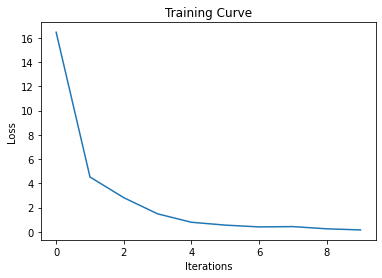

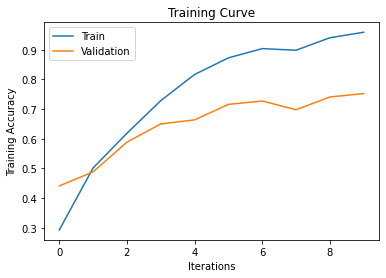

Final Training Accuracy: 0.9591144438493127
Final Validation Accuracy: 0.7522727272727273


In [ ]:
# plot the accuracy graph
plot_accuracy(iters, losses, train_acc, val_acc)

## 5.5 Get Feature types

In [ ]:
# import header to save the feature data into google drive file
import os

# GoogleDrive Data path

feature_train_path = GoogleDrivePath + 'Feature' + '/train/'
feature_val_path = GoogleDrivePath + 'Feature' + '/valid/'
feature_test_path = GoogleDrivePath + 'Feature' + '/test/'

# This will download the Lab_3b_Gesture_Dataset dataset to a folder called "data"
target_classes = ['1', '2', '3', '4']
train_loader, val_loader, test_loader = get_data_loader(train_batch_size = 1, valid_batch_size = 1, test_batch_size = 1) # One image per batch



Start Loading data....
Finish Load data


In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
import imageio
 

def get_image_info(image_dir):
    image_info = Image.open(image_dir).convert('RGB')     # open the image in term of RGB style
    image_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image_info = image_transform(image_info)
    image_info = image_info.unsqueeze(0)
    return image_info
 
def get_k_layer_feature_map(feature_extractor, k, x):
    with torch.no_grad():
        for index,layer in enumerate(feature_extractor):
            x = layer(x)
            if k == index:
                return x
 
def show_feature_map(feature_map):
    feature_map = feature_map.squeeze(0)
    feature_map = feature_map.cpu().numpy()
    feature_map_num = feature_map.shape[0]
    row_num = np.ceil(np.sqrt(feature_map_num))

    fig1 = plt.figure(figsize=(23, 12))
    for index in range(1, feature_map_num+1):
        plt.subplot(row_num, row_num, index)
        plt.imshow(feature_map[index-1])
        plt.axis('off')
        imageio.imwrite(str(index)+".png", feature_map[index-1].astype(np.uint8))

    fig1.show()
 
 
 
def get_featureFunction():
    image_dir = TrainPath + "/1/img_13.jpg"  # example of we random pick the image
    k = 1
    model = models.alexnet(pretrained=True)

    use_gpu = torch.cuda.is_available()
    use_gpu =False

    image_info = get_image_info(image_dir)
    if use_gpu:
        model = model.cuda()
        image_info = image_info.cuda()

    feature_extractor = model.features
    feature_map = get_k_layer_feature_map(feature_extractor, k, image_info)
    show_feature_map(feature_map)


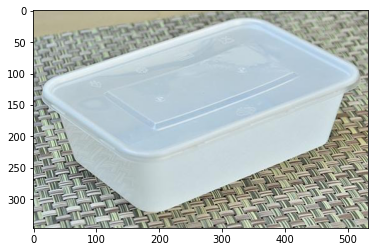

In [ ]:
# Show the actual image

TrainPath = DataPath + 'Train'
import matplotlib.image as mpimg

imagePath = TrainPath + "/1/img_13.jpg"
image = mpimg.imread(imagePath)

plt.imshow(image)


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


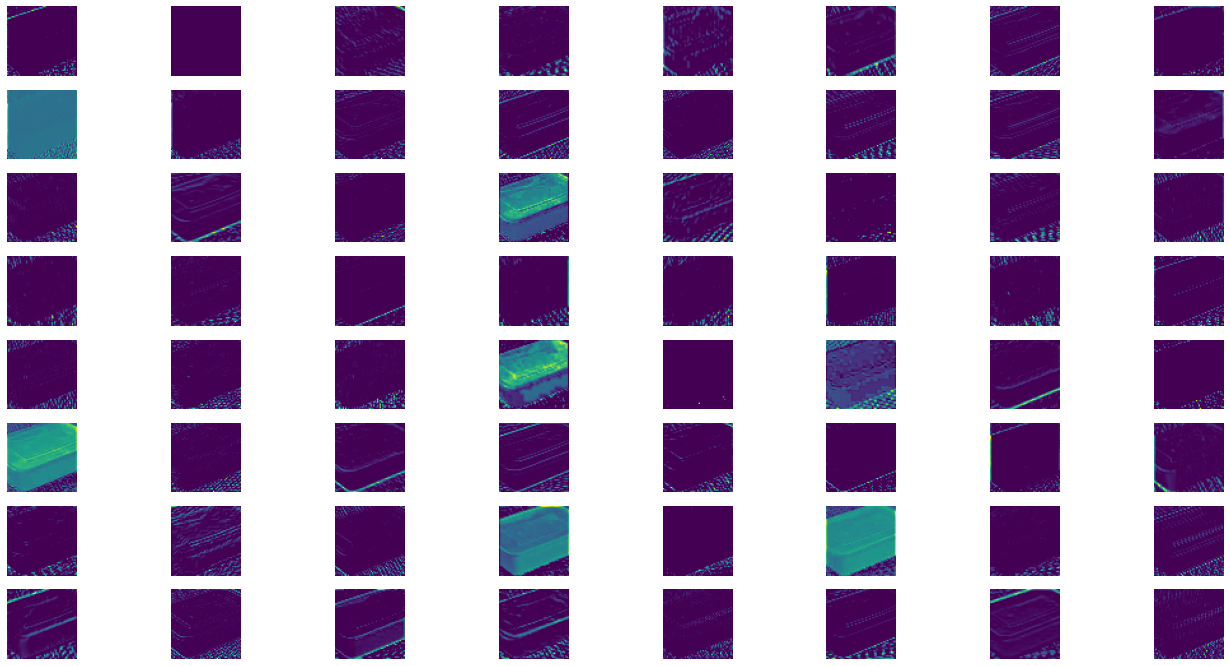

In [ ]:
get_featureFunction()

# 6.0 Demo

## 6.1 Ourput the result in terms of word

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import torchvision.models as models    # Import model.Resnet50
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder


from torch.autograd import Variable
from io import open
import os
from PIL import Image
import pathlib
import glob
import cv2


# Mount with my Google drive 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)

def plot_image(img, label, name):

    fig = plt.figure()
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.tight_layout()
        plt.imshow(img[i][0]*0.3081+0.1307, cmap='gray', interpolation='none')
        plt.title("{}: {}".format(name, label[i].item()))
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [ ]:
import sys
import torch
from PIL import Image
from torchvision import transforms

classes = ('harmful','kitch','others','recyc')
device = torch.device('cuda')
transform=transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406],
                                 std=[0.229,0.224,0.225])
                            ])


class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)

def plot_image(img, label, name):

    fig = plt.figure()
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.tight_layout()
        plt.imshow(img[i][0]*0.3081+0.1307, cmap='gray', interpolation='none')
        plt.title("{}: {}".format(name, label[i].item()))
        plt.xticks([])
        plt.yticks([])
    plt.show()



def prediect(img_path):
    modelPath = GoogleDrivePath + "model.pkl"
    net=torch.load(modelPath)
    net=net.to(device)
    torch.no_grad()
    img=Image.open(img_path)
    img=transform(img).unsqueeze(0)
    img_ = img.to(device)
    outputs = net(img_)
    _, predicted = torch.max(outputs, 1)
    # print(predicted)
    print(classes[predicted[0]])


test_path = GoogleDrivePath + "test/img1-1.jpg"
print(test_path)

prediect(test_path)



/content/gdrive/MyDrive/APS360_Lab/Project/test/img1-1.jpg
harmful


## 6.2 Performance

In [ ]:
# List Google drive data path
GoogleDrivePath = '/content/gdrive/MyDrive/APS360_Lab/Project/'
DataPath = GoogleDrivePath + 'test/'
modePath = GoogleDrivePath + 'model.pkl'


import sys
import torch
from PIL import Image
from torchvision import transforms

classes = ('harmful','kitch','others','recyc')
device = torch.device('cuda')
transform=transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406],
                                 std=[0.229,0.224,0.225])
                            ])
def prediect(img_path):
    net=torch.load(modePath)
    net=net.to(device)
    torch.no_grad()
    img=Image.open(img_path)
    img=transform(img).unsqueeze(0)
    img_ = img.to(device)
    outputs = net(img_)
    _, predicted = torch.max(outputs, 1)
    # print(predicted)
    # print(classes[predicted[0]])
    # print(predicted[0])
    return predicted[0]


def getFileList(dir, Filelist, ext=None):
    newDir = dir
    if os.path.isfile(dir):
        if ext is None:
            Filelist.append(dir)
        else:
            if ext in dir[-3:]:
                Filelist.append(dir)
    
    elif os.path.isdir(dir):
        for s in os.listdir(dir):
            newDir=os.path.join(dir,s)
            getFileList(newDir, Filelist, ext)
 
    return Filelist


In [ ]:
test_path = GoogleDrivePath + "test/"
# print(GoogleDrivePath + "test/4.jpg")

imglist = getFileList(test_path, [], 'jpg')
print('There are '+str(len(imglist))+' Test images\n')

acc = 0

num = 1
for imgpath in imglist:
    # print(imgpath)
    result = prediect(imgpath)
    result = int(result+1)
    # print("result is", result)

    if(result == int(imgpath[-5])):
      acc += 1

    num+=1
print("Test accuracy is: ", acc/num)


There are 16 Test images

Test accuracy is:  0.9411764705882353


## 6.2 App 

Description: We try to connect our model into the app applying https://anvil.works/



APP Link: https://HIOCJ6O7DYMY3P6R.anvil.app/WYRFINY5I5YVMOTYSNJ5QJQQ
Note: this link only work if it have been successfully run all the code below



In [ ]:
# List Google drive data path
GoogleDrivePath = '/content/gdrive/MyDrive/APS360_Lab/Project/'
DataPath = GoogleDrivePath + 'test/'
modePath = GoogleDrivePath + 'model.pkl'


import sys
import torch
from PIL import Image
from torchvision import transforms

classes = ('harmful','kitch','others','recyc')
device = torch.device('cuda')
transform=transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406],
                                 std=[0.229,0.224,0.225])
                            ])
def prediect(img_path):
    net=torch.load(modePath)
    net=net.to(device)
    torch.no_grad()
    img=Image.open(img_path)
    img=transform(img).unsqueeze(0)
    img_ = img.to(device)
    outputs = net(img_)
    _, predicted = torch.max(outputs, 1)
    # print(predicted)
    # print(classes[predicted[0]])
    # print(predicted[0])
    return predicted[0]


def getFileList(dir, Filelist, ext=None):
    newDir = dir
    if os.path.isfile(dir):
        if ext is None:
            Filelist.append(dir)
        else:
            if ext in dir[-3:]:
                Filelist.append(dir)
    
    elif os.path.isdir(dir):
        for s in os.listdir(dir):
            newDir=os.path.join(dir,s)
            getFileList(newDir, Filelist, ext)
 
    return Filelist


    
import sys
import torch
from PIL import Image
from torchvision import transforms

classes = ('harmful','kitch','others','recyc')
device = torch.device('cuda')
transform=transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406],
                                 std=[0.229,0.224,0.225])
                            ])

class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)

def plot_image(img, label, name):

    fig = plt.figure()
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.tight_layout()
        plt.imshow(img[i][0]*0.3081+0.1307, cmap='gray', interpolation='none')
        plt.title("{}: {}".format(name, label[i].item()))
        plt.xticks([])
        plt.yticks([])
    plt.show()



def prediect(img_path):
    modelPath = GoogleDrivePath + "model.pkl"
    net=torch.load(modelPath)
    net=net.to(device)
    torch.no_grad()
    img=Image.open(img_path)
    img=transform(img).unsqueeze(0)
    img_ = img.to(device)
    outputs = net(img_)
    _, predicted = torch.max(outputs, 1)
    # print(predicted)
    print(classes[predicted[0]])



In [ ]:
!pip install anvil-uplink
import anvil.server

     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 61kB 9.2MB/s 
  Created wheel for ws4py: filename=ws4py-0.5.1-cp37-none-any.whl size=45216 sha256=2709f882021a775d4e236156b190ea3d3080f341e35cc75eceec73eaf087b7dc
  Stored in directory: /root/.cache/pip/wheels/a2/6e/4e/8b0ae12fb9b8a05715256952cf7609a8ab86285fab99b88c68
Successfully built ws4py


In [ ]:
anvil.server.connect("LN6VW46V3IVVHTNPTTVGEO5Z-HIOCJ6O7DYMY3P6R")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment (dev)" as SERVER


In [ ]:
import anvil.media

@anvil.server.callable
def classify_image(file):
    with anvil.media.TempFile(file) as filename:
        img=Image.open(filename)
        
    modelPath = GoogleDrivePath + "model.pkl"
    net=torch.load(modelPath)
    net=net.to(device)
    torch.no_grad()
    # img=Image.open(img_path)
    img=transform(img).unsqueeze(0)
    img_ = img.to(device)
    outputs = net(img_)
    _, predicted = torch.max(outputs, 1)
    # print(predicted)
    print(classes[predicted[0]])

    return classes[predicted[0]]

In [ ]:
anvil.server.wait_forever()

# 8.0 End